In [48]:
import numpy as np

from IPython.display import  clear_output
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import collections

**Introduce experience replay.**

In [49]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device='cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        transitions = [self.memory[idx] for idx in indices]
        states = np.stack([np.array(t[0]) for t in transitions])
        actions = np.stack([np.array(t[1]) for t in transitions])
        next_states = np.stack([np.array(t[2]) for t in transitions])
        rewards = np.stack([np.array(t[3]) for t in transitions])
        isgameon = np.stack([np.array(t[4]) for t in transitions])

        return torch.from_numpy(states).to(device=device, dtype=torch.float), \
               torch.from_numpy(actions).to(device=device, dtype=torch.long), \
               torch.from_numpy(next_states).to(device=device, dtype=torch.float), \
               torch.from_numpy(rewards).to(device=device, dtype=torch.float), \
               torch.from_numpy(isgameon).to(device=device, dtype=torch.float)


**Networks definition.**

In [50]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2, ZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

torch.backends.cudnn.benchmark = True

In [51]:
num_qubits = 4

def create_qnn():
    qc = QuantumCircuit(num_qubits)
    feature_map = ZZFeatureMap(num_qubits)
    #feature_map = ZFeatureMap(num_qubits)
    #ansatz = EfficientSU2(num_qubits=num_qubits, reps=7)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=8)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

qnn = create_qnn()
print("QNN Training Parameters: ", qnn.num_weights)

QNN Training Parameters:  36


In [52]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh, Nh2, No = 4, qnn = qnn):
        super().__init__()
        self.fc1 = nn.Linear(Ni, Nh)
        self.fc2 = nn.Linear(Nh, Nh2)
        self.fc3 = nn.Linear(Nh2, num_qubits)
        self.qnn = TorchConnector(qnn)
        self.fc4 = nn.Linear(1, 1)
        self.fc5 = Linear(1, No) 
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.qnn(x)
        x = self.fc4(x)
        x = self.act(self.fc5(x))

        return x 

In [53]:
def Qloss(batch, net, gamma=0.99, device="cuda"):
    states, actions, next_states, rewards, _ = batch

    # Move tensors to the desired device
    states = states.to(device)
    actions = actions.to(device)
    next_states = next_states.to(device)
    rewards = rewards.to(device)

    # Convert states and next_states to NumPy arrays
    states = states.cpu().detach().numpy()
    next_states = next_states.cpu().detach().numpy()

    # Create PyTorch tensors from the NumPy arrays
    states_tensor = torch.from_numpy(states).to(device)
    next_states_tensor = torch.from_numpy(next_states).to(device)

    # Perform the rest of the computation on the device
    lbatch = len(states_tensor)
    state_action_values = net(states_tensor.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    #state_action_values = torch.tensor(input_list).squeeze()
    
    next_state_values = net(next_states_tensor.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards
    
    return nn.MSELoss()(state_action_values, expected_state_action_values)

**Import the maze and define the environment.**

In [54]:
from environment import MazeEnvironment

maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)

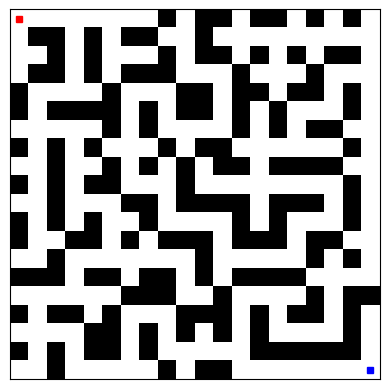

In [55]:
maze_env.draw('maze_10.pdf')

**Define the agent and the buffer for experience replay.**

In [56]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [57]:
from agent import Agent

agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

** Define the network.**

In [58]:
net = fc_nn(int(maze.size/2), int(maze.size/2), int(maze.size/2), 4, qnn)
print("Maze Size: ", maze.size/10)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

Maze Size:  40.0


In [59]:
device = 'cuda'
batch_size = 16
print("Batch Size: ", batch_size)
gamma = 0.99

net.to(device)
print("Number of trainable parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

Batch Size:  16
Number of trainable parameters:  81250


**Define the epsilon profile and plot the resetting probability.**

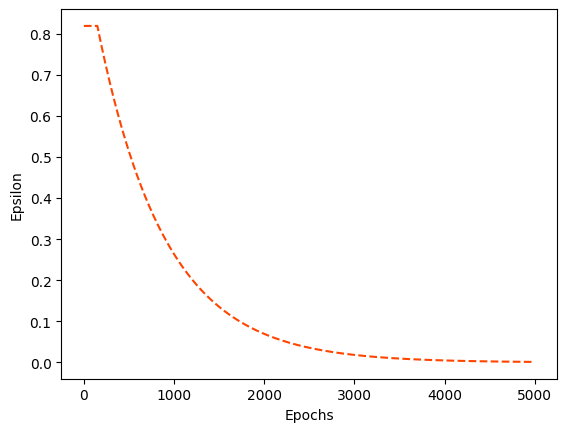

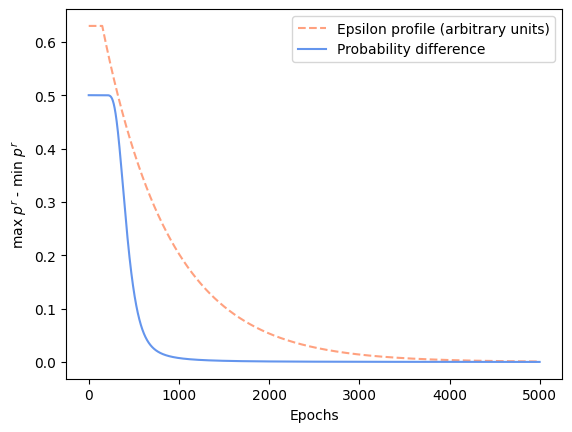

In [60]:
num_epochs = 5000

cutoff = 750
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[25*int(num_epochs/cutoff)]] = epsilon[25*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()


**Training the network.**

In [61]:

best_loss = 1e5

running_loss = 0

for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)
    
    while agent.isgameon:
        agent.make_a_move(net, eps)
        counter += 1
        
        if len(agent.buffer) < buffer_start_size:
            continue
            
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device = device)
        loss_t = Qloss(batch, net, gamma = gamma, device = device)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()
    
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'   
    
    if epoch%100 == 0:
        agent.save_model(net, 'sol_epoch_'+str(epoch)+'.pt')
        
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
        
    clear_output(wait = True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x400 and 200x200)

In [ ]:
torch.save(net.state_dict(), "quantumDNN.torch")

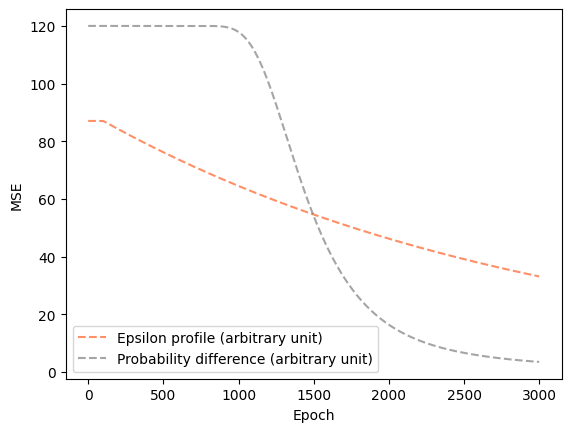

In [ ]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig('loss.pdf', dpi = 300, bbox_inches='tight')
plt.show()

**Show the maze solution and the policy learnt.**

In [ ]:
net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(net, 0)
    agent.env.draw('')
    clear_output(wait = True)

In [ ]:
agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])

In [ ]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('best.torch'))

In [ ]:
agent.plot_policy_map(best_net, 'solution_best.pdf', [0.35,-0.3])

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright